# Explore *hrp2* and *hrp3* deletion breakpoints

## Introduction

This notebook will create a figure of histidine-rich protein (*hrp*) 2 and *hrp3* deletion breakpoints.

*hrp2* and *hrp3* are genes located in subtelomeric regions of the genome with very high levels of natural variation. Deletion in those genes can cause failure of rapid diagnostic tests and is therefore important to monitor.

Deletion is a genetic event in which a segment of DNA is entirely removed or missing. In this context, 'breakpoints' denote specific locations on the chromosome where such deletions take place.

**This notebook should take approximately two minutes to run.**

## Setup

Install and import the malariagen Python package:

In [1]:
!pip install malariagen_data -q --no-warn-conflicts
import malariagen_data

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 33.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.9/775.9 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.9/25.9 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Import required python libraries that are installed at colab by default.

In [2]:
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
from google.colab import drive

## Access Pf8 Data

We use the malariagen data package to load the release data.

In [3]:
release_data = malariagen_data.Pf8()
df_samples = release_data.sample_metadata()

## *hrp2* & *hrp3* Deletions

We additionally require list of deletion and breakpoint locations within the *hrp2* and *hrp3* across 24,409 QC-pass samples. We can access this data along with other copy-number variation (CNV) calls from [Sanger cloud storage](https://pf8-release.cog.sanger.ac.uk/Pf8_cnv_calls.tsv).

In [4]:
# Read data directly from url
hrp_calls_fn = pd.read_csv('https://pf8-release.cog.sanger.ac.uk/Pf8_cnv_calls.tsv', sep='\t') 

# Print the shape and first rows
print(hrp_calls_fn.shape)
hrp_calls_fn.head()

(24409, 29)


Sample  CRT_uncurated_coverage_only  CRT_curated_coverage_only  \
0   FP0008-C                            0                          0   
1   FP0009-C                            0                          0   
2  FP0010-CW                           -1                         -1   
3  FP0011-CW                           -1                         -1   
4  FP0012-CW                           -1                         -1   

  CRT_breakpoint  CRT_faceaway_only  CRT_final_amplification_call  \
0              -                 -1                             0   
1              -                  0                             0   
2              -                  0                             0   
3              -                 -1                            -1   
4              -                  0                             0   

   GCH1_uncurated_coverage_only  GCH1_curated_coverage_only GCH1_breakpoint  \
0                            -1                          -1               -   
1                             0                           0               -   
2                            -1                          -1               -   
3                            -1                          -1               -   
4                             0                           0               -   

   GCH1_faceaway_only  ...  PM2_PM3_faceaway_only  \
0                   0  ...                      0   
1                   0  ...                      0   
2                   0  ...                      0   
3                   0  ...                      0   
4                   0  ...                      0   

   PM2_PM3_final_amplification_call  HRP2_uncurated_coverage_only  \
0                                 0                             0   
1                                 0                             0   
2                                 0                            -1   
3                                 0                            -1   
4                                 0                            -1   

  HRP2_breakpoint  HRP2_deletion_type  HRP2_final_deletion_call  \
0               -                   -                         0   
1               -                   -                         0   
2               -                   -                        -1   
3               -                   -                        -1   
4               -                   -                        -1   

   HRP3_uncurated_coverage_only  HRP3_breakpoint HRP3_deletion_type  \
0                             0                -                  -   
1                             0                -                  -   
2                            -1                -                  -   
3                            -1                -                  -   
4                             0                -                  -   

   HRP3_final_deletion_call  
0                         0  
1                         0  
2                        -1  
3                        -1  
4                         0  

[5 rows x 29 columns]

Now, let's merge `hrp_calls_fn` with `df_samples` which contains various metadata of Pf8 samples.

In [7]:
# Merge df_samples with hrp_calls_fn
df_samples =  df_samples.merge(hrp_calls_fn, on ='Sample')

## 3D7 Reference Genome Annotation

We would like to know where breakpoints occur in the genome, such as whether they fall within protein-coding regions or mRNA regions.

To facilitate this, we will use the 3D7 reference genome annotation. This data is in a tabular format where each row specifies a genomic feature, such as an exon, mRNA, or protein-coding gene, along with its corresponding coordinates (`start` and `end` columns). For more information about the annotation data format, refer to this [wiki page](https://en.wikipedia.org/wiki/General_feature_format#:~:text=In%20bioinformatics%2C%20the%20general%20feature,.gff%20%2C%20.gff3).

This dataset is available through the malariagen_data package.

In [8]:
df_gff= release_data.genome_features()

# print first rows
df_gff.head()

contig     source                 type   start     end  score strand  \
0  Pf3D7_13_v3  VEuPathDB  protein_coding_gene  624510  626292    NaN      +   
1  Pf3D7_13_v3  VEuPathDB                 mRNA  624510  626292    NaN      +   
2  Pf3D7_13_v3  VEuPathDB                 exon  624510  626292    NaN      +   
3  Pf3D7_13_v3  VEuPathDB                  CDS  624785  626011    NaN      +   
4  Pf3D7_13_v3  VEuPathDB       five_prime_UTR  624510  624784    NaN      +   

   phase                       ID           Parent   Name  
0    NaN            PF3D7_1314600              NaN  LipL1  
1    NaN          PF3D7_1314600.1    PF3D7_1314600    NaN  
2    NaN  exon_PF3D7_1314600.1-E1  PF3D7_1314600.1    NaN  
3    0.0  PF3D7_1314600.1-p1-CDS1  PF3D7_1314600.1    NaN  
4    NaN    utr_PF3D7_1314600.1_1  PF3D7_1314600.1    NaN

## Figure Preparation

We need to find the start and end positions of chromosomes ('contig' column in the dataframe) to draw gene annotations in the figure that we are going to create.

In [9]:
# Find start and end positions for each chromosome by grouping chromosome coordinates
df_chroms = df_gff.groupby('contig').agg({'start': 'min', 'end': 'max'}).reset_index()
# Set 'chrom' as the index
df_chroms.set_index('contig', inplace=True)
df_chroms

start      end
contig                      
Pf3D7_01_v3   29510   614893
Pf3D7_02_v3   25232   923648
Pf3D7_03_v3   36965  1038254
Pf3D7_04_v3   28706  1180226
Pf3D7_05_v3   20929  1342964
Pf3D7_06_v3     653  1382627
Pf3D7_07_v3   20307  1426234
Pf3D7_08_v3   21361  1443449
Pf3D7_09_v3   20080  1503336
Pf3D7_10_v3   28490  1649948
Pf3D7_11_v3   24160  2035886
Pf3D7_12_v3   16973  2248962
Pf3D7_13_v3   21364  2892340
Pf3D7_14_v3    1393  3291501
Pf3D7_API_v3      1    34225
Pf3D7_MIT_v3      3     5954

The next question is: How many samples have deletions in each country?

In [10]:
# This function returns samples with deletion for each country.

def breakpoint_agg(x):
    names = collections.OrderedDict()
    names['Countries'] = ''
    countries = []
    # Loop over each country
    # Count non-zero samples (with deletion)
    for country in x['Country'].unique():
        countries.append(f"{country} ({np.count_nonzero(x['Country'] == country)})")
    # Join together country name and number
    names['Countries'] = ', '.join(countries)
    names['Samples with deletion'] = len(x)
    return pd.Series(names)

We will apply `breakpoint_agg` function to `df_samples` separately for *hrp2* and *hrp3*.

Additionally, we will find genomic coordinates at the edges for mapping in the figure.

In [12]:
# Group samples by Deletion type and HRP3_breakpoint
# Apply breakpoint_agg to count samples with deletion in each country
df_hrp2 = (
    df_samples[
        df_samples['QC pass']
        & ( df_samples['HRP2_final_deletion_call'] == 1 )
    ]
    .assign(Gene='$hrp2$')
    .rename(columns={'HRP2_deletion_type': 'Deletion type'})
    .groupby(['Deletion type', 'HRP2_breakpoint'])
    .apply(breakpoint_agg, include_groups=False)
    .reset_index()
)
# Seperate coordinate value from chromosome
df_hrp2['breakpoint'] = df_hrp2['HRP2_breakpoint'].apply(lambda x: int(x.split(':')[1]))

# Print min and max coordinates
print(f"HRP2 min breakpoint = {df_hrp2['breakpoint'].min()}")
print(f"HRP2 max breakpoint = {df_hrp2['breakpoint'].max()}")
df_hrp2

HRP2 min breakpoint = 1373732
HRP2 max breakpoint = 1374986


Deletion type      HRP2_breakpoint      Countries  \
0  Telomere healing  Pf3D7_08_v3:1373732   Cambodia (1)   
1  Telomere healing  Pf3D7_08_v3:1374280      Sudan (1)   
2  Telomere healing  Pf3D7_08_v3:1374462  Indonesia (5)   
3  Telomere healing  Pf3D7_08_v3:1374932       Peru (2)   
4  Telomere healing  Pf3D7_08_v3:1374986       Peru (6)   

   Samples with deletion  breakpoint  
0                      1     1373732  
1                      1     1374280  
2                      5     1374462  
3                      2     1374932  
4                      6     1374986

A repeat of the same look-up for *hrp3*.

In [13]:
# Group samples by Deletion type and HRP3_breakpoint
# Apply breakpoint_agg to count samples with deletion in each country
df_hrp3 = (
    df_samples[
        df_samples['QC pass']
        & ( df_samples['HRP3_final_deletion_call'] == 1 )
    ]
    .rename(columns={'HRP3_deletion_type': 'Deletion type'})
    .groupby(['Deletion type', 'HRP3_breakpoint'])
    .apply(breakpoint_agg, include_groups=False)
    .reset_index()
)
# Seperate coordinate value from chromosome
df_hrp3['breakpoint'] = df_hrp3['HRP3_breakpoint'].apply(lambda x: x.split(':')[1])

# Print min and max coordinates
print(f"HRP3 min breakpoint = {df_hrp3['breakpoint'].min()}")
print(f"HRP3 max breakpoint = {df_hrp3['breakpoint'].max()}")
df_hrp3

HRP3 min breakpoint = 2800004-2807159
HRP3 max breakpoint = 2841120


Deletion type              HRP3_breakpoint  \
0   Chromosome 11 recombination  Pf3D7_13_v3:2800004-2807159   
1    Chromosome 5 recombination  Pf3D7_13_v3:2835587-2835612   
2              Telomere healing          Pf3D7_13_v3:2811525   
3              Telomere healing          Pf3D7_13_v3:2812344   
4              Telomere healing          Pf3D7_13_v3:2815249   
5              Telomere healing          Pf3D7_13_v3:2822480   
6              Telomere healing          Pf3D7_13_v3:2823645   
7              Telomere healing          Pf3D7_13_v3:2830952   
8              Telomere healing          Pf3D7_13_v3:2834604   
9              Telomere healing          Pf3D7_13_v3:2835532   
10             Telomere healing          Pf3D7_13_v3:2835899   
11             Telomere healing          Pf3D7_13_v3:2837144   
12             Telomere healing          Pf3D7_13_v3:2837392   
13             Telomere healing          Pf3D7_13_v3:2838654   
14             Telomere healing          Pf3D7_13_v3:2840859   
15             Telomere healing          Pf3D7_13_v3:2841024   
16             Telomere healing          Pf3D7_13_v3:2841120   

                                            Countries  Samples with deletion  \
0   Thailand (1), Ghana (3), Indonesia (38), Peru ...                    162   
1                          Cambodia (20), Vietnam (1)                     21   
2                                           India (1)                      1   
3                                           Sudan (1)                      1   
4                                        Tanzania (1)                      1   
5                                           Ghana (1)                      1   
6                                           Kenya (1)                      1   
7                                        Cambodia (7)                      7   
8                                         Vietnam (1)                      1   
9                                        Thailand (1)                      1   
10                                          Ghana (1)                      1   
11                                        Vietnam (8)                      8   
12                             Cambodia (2), Laos (1)                      3   
13                                      Indonesia (2)                      2   
14                                         Gambia (2)                      2   
15                                       Thailand (1)                      1   
16                                      Indonesia (1)                      1   

         breakpoint  
0   2800004-2807159  
1   2835587-2835612  
2           2811525  
3           2812344  
4           2815249  
5           2822480  
6           2823645  
7           2830952  
8           2834604  
9           2835532  
10          2835899  
11          2837144  
12          2837392  
13          2838654  
14          2840859  
15          2841024  
16          2841120

It seems that Chromosome 11 recombination breakpoints are observed in multiple countries which motivates us to print the full list of countries.

In [14]:
# Locate the first row by using the index
df_hrp3.iloc[0]['Countries']

'Thailand (1), Ghana (3), Indonesia (38), Peru (15), Bangladesh (1), Vietnam (2), Colombia (50), Ethiopia (9), Senegal (6), Laos (19), Cambodia (3), Sudan (6), Mali (1), Gambia (7), Kenya (1)'

Given the fact that many of these events result in the deletion of other genes in addition to *hrp2* and *hrp3*.

We could have a look at which genes are present within the range of breakpoints before including them in the plot.

In [15]:
# Genes in hrp2 breakpoints
df_gff.loc[
    ( df_gff['contig'] == 'Pf3D7_08_v3' )
    & ( df_gff['start'] <= 1375500 )
    & ( df_gff['end'] >= 1364000 )
]

contig     source                    type    start      end  \
17090  Pf3D7_08_v3  VEuPathDB     protein_coding_gene  1373212  1376988   
17091  Pf3D7_08_v3  VEuPathDB                    mRNA  1373212  1376988   
17092  Pf3D7_08_v3  VEuPathDB                    exon  1373212  1375084   
17093  Pf3D7_08_v3  VEuPathDB                    exon  1375231  1376988   
17094  Pf3D7_08_v3  VEuPathDB                     CDS  1374236  1375084   
17095  Pf3D7_08_v3  VEuPathDB                     CDS  1375231  1375299   
17096  Pf3D7_08_v3  VEuPathDB         three_prime_UTR  1373212  1374235   
17097  Pf3D7_08_v3  VEuPathDB          five_prime_UTR  1375300  1376988   
27865  Pf3D7_08_v3  VEuPathDB     protein_coding_gene  1364640  1369862   
27866  Pf3D7_08_v3  VEuPathDB                    mRNA  1364640  1369862   
27867  Pf3D7_08_v3  VEuPathDB                    exon  1364640  1367640   
27868  Pf3D7_08_v3  VEuPathDB                    exon  1368649  1369862   
27869  Pf3D7_08_v3  VEuPathDB                     CDS  1365467  1367506   
27870  Pf3D7_08_v3  VEuPathDB         three_prime_UTR  1364640  1365466   
27871  Pf3D7_08_v3  VEuPathDB          five_prime_UTR  1367507  1367640   
27872  Pf3D7_08_v3  VEuPathDB          five_prime_UTR  1368649  1369862   
28984  Pf3D7_08_v3  VEuPathDB              pseudogene  1371847  1372720   
28985  Pf3D7_08_v3  VEuPathDB  pseudogenic_transcript  1371847  1372720   
28986  Pf3D7_08_v3  VEuPathDB                    exon  1371847  1372100   
28987  Pf3D7_08_v3  VEuPathDB                    exon  1372103  1372223   
28988  Pf3D7_08_v3  VEuPathDB                    exon  1372225  1372291   
28989  Pf3D7_08_v3  VEuPathDB                    exon  1372294  1372577   
28990  Pf3D7_08_v3  VEuPathDB                    exon  1372579  1372667   
28991  Pf3D7_08_v3  VEuPathDB                    exon  1372669  1372720   
28992  Pf3D7_08_v3  VEuPathDB                     CDS  1371847  1372100   
28993  Pf3D7_08_v3  VEuPathDB                     CDS  1372103  1372223   
28994  Pf3D7_08_v3  VEuPathDB                     CDS  1372225  1372291   
28995  Pf3D7_08_v3  VEuPathDB                     CDS  1372294  1372403   
28996  Pf3D7_08_v3  VEuPathDB         three_prime_UTR  1372404  1372577   
28997  Pf3D7_08_v3  VEuPathDB         three_prime_UTR  1372579  1372667   
28998  Pf3D7_08_v3  VEuPathDB         three_prime_UTR  1372669  1372720   

       score strand  phase                       ID           Parent    Name  
17090    NaN      -    NaN            PF3D7_0831800              NaN    HRP2  
17091    NaN      -    NaN          PF3D7_0831800.1    PF3D7_0831800     NaN  
17092    NaN      -    NaN  exon_PF3D7_0831800.1-E2  PF3D7_0831800.1     NaN  
17093    NaN      -    NaN  exon_PF3D7_0831800.1-E1  PF3D7_0831800.1     NaN  
17094    NaN      -    0.0  PF3D7_0831800.1-p1-CDS2  PF3D7_0831800.1     NaN  
17095    NaN      -    0.0  PF3D7_0831800.1-p1-CDS1  PF3D7_0831800.1     NaN  
17096    NaN      -    NaN    utr_PF3D7_0831800.1_1  PF3D7_0831800.1     NaN  
17097    NaN      -    NaN    utr_PF3D7_0831800.1_2  PF3D7_0831800.1     NaN  
27865    NaN      -    NaN            PF3D7_0831700              NaN  HSP70x  
27866    NaN      -    NaN          PF3D7_0831700.1    PF3D7_0831700     NaN  
27867    NaN      -    NaN  exon_PF3D7_0831700.1-E2  PF3D7_0831700.1     NaN  
27868    NaN      -    NaN  exon_PF3D7_0831700.1-E1  PF3D7_0831700.1     NaN  
27869    NaN      -    0.0  PF3D7_0831700.1-p1-CDS1  PF3D7_0831700.1     NaN  
27870    NaN      -    NaN    utr_PF3D7_0831700.1_1  PF3D7_0831700.1     NaN  
27871    NaN      -    NaN    utr_PF3D7_0831700.1_2  PF3D7_0831700.1     NaN  
27872    NaN      -    NaN    utr_PF3D7_0831700.1_3  PF3D7_0831700.1     NaN  
28984    NaN      +    NaN            PF3D7_0831750              NaN     NaN  
28985    NaN      +    NaN          PF3D7_0831750.1    PF3D7_0831750     NaN  
28986    NaN      +    NaN  exon_PF3D7_0831750.1-E1  PF3D7_0831750.1     NaN  
28987    NaN      +    NaN  exo

In [16]:
# Genes in hrp3 breakpoints
pd.options.display.max_rows = 100
df_gff.loc[
    ( df_gff['contig'] == 'Pf3D7_13_v3' )
    & ( df_gff['start'] <= 2845000 )
    & ( df_gff['end'] >= 2795000 )
]

contig     source                    type    start      end  \
17986  Pf3D7_13_v3  VEuPathDB              pseudogene  2811706  2820270   
17987  Pf3D7_13_v3  VEuPathDB  pseudogenic_transcript  2811706  2820270   
17988  Pf3D7_13_v3  VEuPathDB                    exon  2811706  2812263   
17989  Pf3D7_13_v3  VEuPathDB                    exon  2812266  2819628   
17990  Pf3D7_13_v3  VEuPathDB                    exon  2819764  2819851   
17991  Pf3D7_13_v3  VEuPathDB                    exon  2820015  2820088   
17992  Pf3D7_13_v3  VEuPathDB                    exon  2820227  2820270   
17993  Pf3D7_13_v3  VEuPathDB                     CDS  2811706  2812263   
17994  Pf3D7_13_v3  VEuPathDB                     CDS  2812266  2815526   
17995  Pf3D7_13_v3  VEuPathDB         three_prime_UTR  2815527  2819628   
17996  Pf3D7_13_v3  VEuPathDB         three_prime_UTR  2819764  2819851   
17997  Pf3D7_13_v3  VEuPathDB         three_prime_UTR  2820015  2820088   
17998  Pf3D7_13_v3  VEuPathDB         three_prime_UTR  2820227  2820270   
28226  Pf3D7_13_v3  VEuPathDB     protein_coding_gene  2835756  2839580   
28227  Pf3D7_13_v3  VEuPathDB                    mRNA  2835756  2839580   
28228  Pf3D7_13_v3  VEuPathDB                    exon  2835756  2837136   
28229  Pf3D7_13_v3  VEuPathDB                    exon  2837313  2839580   
28230  Pf3D7_13_v3  VEuPathDB                     CDS  2837053  2837136   
28231  Pf3D7_13_v3  VEuPathDB                     CDS  2837313  2839058   
28232  Pf3D7_13_v3  VEuPathDB          five_prime_UTR  2835756  2837052   
28233  Pf3D7_13_v3  VEuPathDB         three_prime_UTR  2839059  2839580   
30629  Pf3D7_13_v3  VEuPathDB              ncRNA_gene  2796119  2797144   
30630  Pf3D7_13_v3  VEuPathDB                   ncRNA  2796119  2797144   
30631  Pf3D7_13_v3  VEuPathDB                    exon  2796119  2797144   
31628  Pf3D7_13_v3  VEuPathDB              ncRNA_gene  2797507  2798103   
31629  Pf3D7_13_v3  VEuPathDB                   ncRNA  2797507  2798103   
31630  Pf3D7_13_v3  VEuPathDB                    exon  2797507  2798103   
34729  Pf3D7_13_v3  VEuPathDB     protein_coding_gene  2808200  2810256   
34730  Pf3D7_13_v3  VEuPathDB                    mRNA  2808200  2810256   
34731  Pf3D7_13_v3  VEuPathDB                    exon  2808200  2809000   
34732  Pf3D7_13_v3  VEuPathDB                    exon  2809154  2810256   
34733  Pf3D7_13_v3  VEuPathDB                     CDS  2808563  2809000   
34734  Pf3D7_13_v3  VEuPathDB                     CDS  2809154  2809222   
34735  Pf3D7_13_v3  VEuPathDB         three_prime_UTR  2808200  2808562   
34736  Pf3D7_13_v3  VEuPathDB          five_prime_UTR  2809223  2810256   
35981  Pf3D7_13_v3  VEuPathDB     protein_coding_gene  2840236  2842840   
35982  Pf3D7_13_v3  VEuPathDB                    mRNA  2840236  2842840   
35983  Pf3D7_13_v3  VEuPathDB                    exon  2840236  2841485   
35984  Pf3D7_13_v3  VEuPathDB                    exon  2841635  2841716   
35985  Pf3D7_13_v3  VEuPathDB                    exon  2842024  2842840   
35986  Pf3D7_13_v3  VEuPathDB                     CDS  2840727  2841485   
35987  Pf3D7_13_v3  VEuPathDB                     CDS  2841635  2841703   
35988  Pf3D7_13_v3  VEuPathDB         three_prime_UTR  2840236  2840726   
35989  Pf3D7_13_v3  VEuPathDB          five_prime_UTR  2841704  2841716   
35990  Pf3D7_13_v3  VEuPathDB          five_prime_UTR  2842024  2842840   
36301  Pf3D7_13_v3  VEuPathDB              ncRNA_gene  2802945  2807159   
36302  Pf3D7_13_v3  VEuPathDB                    rRNA  2802945  2807159   
36303  Pf3D7_13_v3  VEuPathDB                    exon  2802945  2807159   
37550  Pf3D7_13_v3  VEuPathDB     protein_coding_gene  2823251  2825967   
37551  Pf3D7_13_v3  VEuPathDB                    mRNA  2823251  2825967   
37552  Pf3D7_13_v3  VEuPathDB                    exon  2823251  2825552   
37553  Pf3D7_13_v3  VEuPathDB                    exon  2825781  2825967   
37554  Pf3D7_13_v3  VEuPathDB        

## Create Figure

This intricate figure serves to map deletion breakpoints in *hrp2* and *hrp3* across various countries. The x-axis of the figure displays the deletion breakpoints, while the y-axis shows the countries along with the number of breakpoints they exhibit.

The figure comprises two sections: *hrp2* (positioned at the top, subplots 1-5) and *hrp3* (located at the bottom, subplots 6-12), consisting of a total of 12 subplots.


We start by defining distinct colour codes for each genomic region that we will annotate.

In [17]:
# Create a dictionary with distinct colour codes
figure_colours = collections.OrderedDict()
figure_colours['chr_8_13'] = '#377eb8'
figure_colours['chr_11'] = '#984ea3'
figure_colours['chr_5'] = '#ff7f00'
figure_colours['similar_sequence'] = '#ffff33'
figure_colours['hrp_genes'] = '#e41a1c'
figure_colours['rrna_genes'] = '#4daf4a'
figure_colours['other_genes'] = 'black'
figure_colours['pseudogenes'] = 'grey'

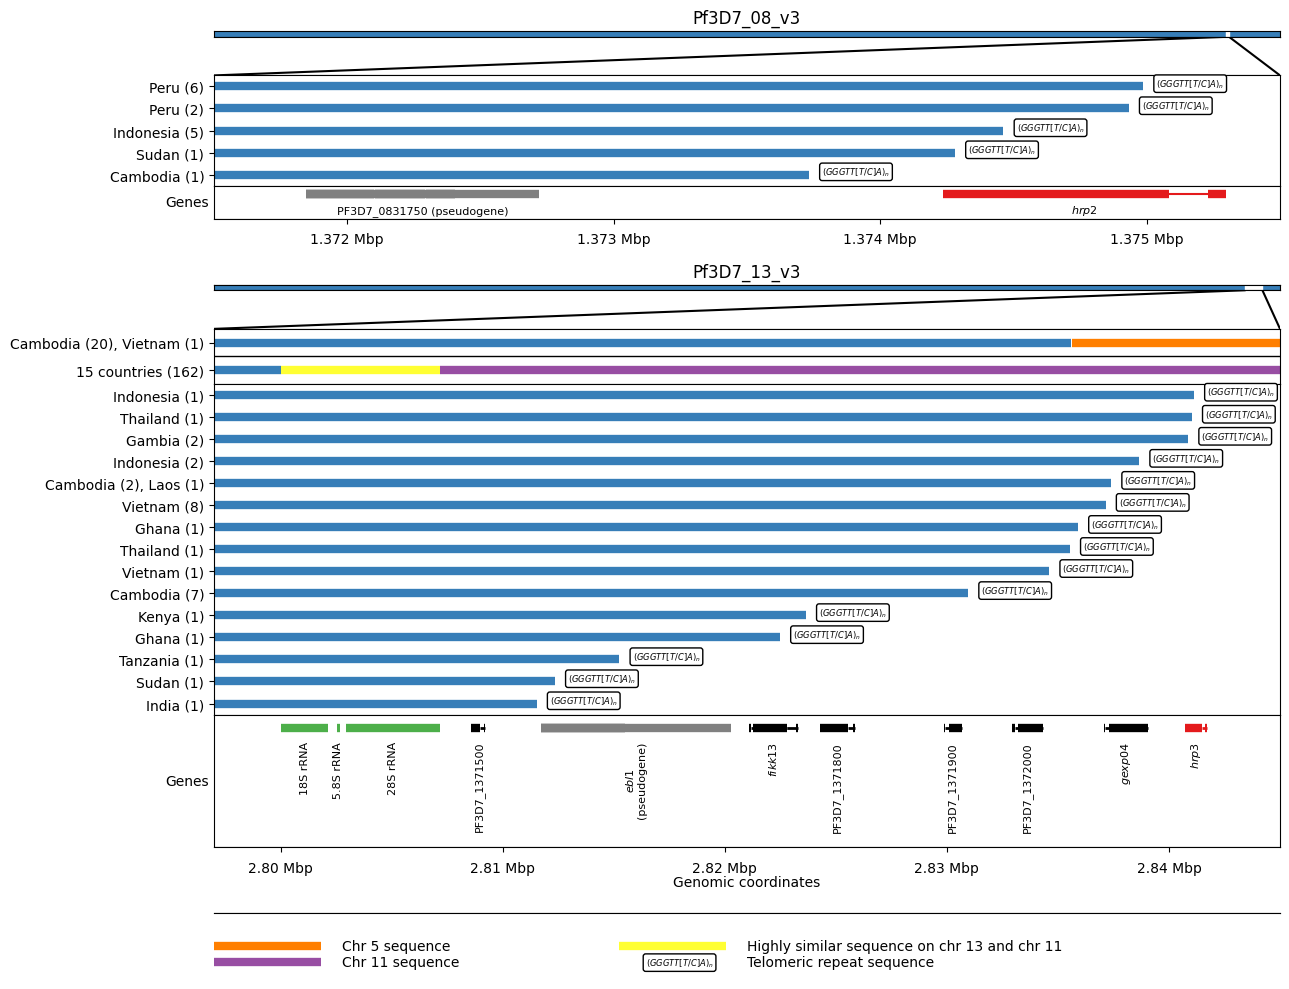

In [18]:
# Full figure

# The figure will consist of 12 subplots, each with varying sizes.
fig, axs = plt.subplots(12, 1, figsize=(13, 10), gridspec_kw={'height_ratios': [1, 7, 20, 6, 12, 1, 7, 10, 60, 24, 12, 12], 'hspace': 0})

### HRP2 (upper panel)

# Set the minimum and maximum positions for hrp2

min_pos = 1371500
max_pos = 1375500

## Subplot 1: Chromosome Title and Region

# Set the title
axs[0].set_title('Pf3D7_08_v3')
# Don't display other properties here
axs[0].set_xticks([])
axs[0].set_xlabel(None)
axs[0].set_yticks([])
axs[0].set_xlim(int(df_chroms.loc['Pf3D7_08_v3', 'start']), int(df_chroms.loc['Pf3D7_08_v3', 'end']))
axs[0].set_facecolor(figure_colours['chr_8_13'])
axs[0].axvspan(min_pos, max_pos, color='white')

## Subplot 2: Chromosome Boundaries

axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_xlim(int(df_chroms.loc['Pf3D7_08_v3', 'start']), int(df_chroms.loc['Pf3D7_08_v3', 'end']))
axs[1].set_ylim(0, 1)
axs[1].plot([int(df_chroms.loc['Pf3D7_08_v3', 'start']), min_pos], [0, 1], '-', color='black')
axs[1].plot([int(df_chroms.loc['Pf3D7_08_v3', 'end']), max_pos], [0, 1], '-', color='black')
axs[1].spines['left'].set_visible(False)
axs[1].spines['right'].set_visible(False)

# Subplot 3: Deletion Breakpoints by Country

# Create lists for y-axis labels and positions
ylabels = []
yposes = []
for ypos, row in df_hrp2.sort_values('breakpoint', ascending=False).iterrows():
    yposes.append(ypos)
    axs[2].plot((min_pos, row['breakpoint']), (ypos, ypos), linewidth=6, solid_capstyle='butt', color=figure_colours['chr_8_13'])
    axs[2].text(row['breakpoint'] + 50, ypos , '$(GGGTT[T/C]A)_n$', fontsize=6, ha='left', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    ylabels.append(f"{row['Countries']}")

axs[2].set_yticks(yposes)
axs[2].set_yticklabels(ylabels)
axs[2].set_xlim(min_pos, max_pos)
axs[2].set_ylim(min(yposes)-0.5, max(yposes)+0.5)
axs[2].set_xticks([])

## Subplot 4: Genes on the x-axis

axs[3].set_xlim(min_pos, max_pos)
axs[3].set_ylim(0, 1)

for ix, row in df_gff.loc[
    ( df_gff['contig'] == 'Pf3D7_08_v3' )
    & ( df_gff['start'] <= max_pos )
    & ( df_gff['end'] >= min_pos )
    & ( df_gff['type'] == 'CDS' )
].iterrows():
    if row['start'] >= 1373212 and row['end'] <= 1376988:
        color=figure_colours['hrp_genes']
    else:
        color=figure_colours['other_genes']
    axs[3].plot((row['start'], row['end']), (0.75, 0.75), linewidth=6, solid_capstyle='butt', color=color)

for ix, row in df_gff.loc[
    ( df_gff['contig'] == 'Pf3D7_08_v3' )
    & ( df_gff['start'] <= max_pos )
    & ( df_gff['end'] >= min_pos )
    & ( df_gff['type'] == 'pseudogene' )
].iterrows():
    axs[3].plot((row['start'], row['end']), (0.75, 0.75), linewidth=6, solid_capstyle='butt', color=figure_colours['pseudogenes'])

# Add gene names for hrp2 panel
axs[3].text(( 1375299 + 1374236 ) / 2, 0.25, '${hrp2}$', va='center', ha='center', size=8)
axs[3].text(( 1371847 + 1372720 ) / 2, 0.25, 'PF3D7_0831750 (pseudogene)', va='center', ha='center', size=8)
axs[3].set_yticks([])
axs[3].set_xticks([])
axs[3].set_ylabel('Genes', rotation=0, ha='right', va='center')
# Add a connection line for the gene
axs[3].plot((1_375_084, 1_375_231), (0.75, 0.75), c = figure_colours['hrp_genes'])

## Subplot 5: Ticks for Genomic Coordinates
# Set the x-axis limits to cover the specified genomic region between 'min_pos' and 'max_pos'
axs[4].set_xlim(min_pos, max_pos)
# Hide the left and right spines to create a cleaner appearance
axs[4].spines['left'].set_visible(False)
axs[4].spines['right'].set_visible(False)
# Configure the x-axis ticks at specific positions
axs[4].set_xticks([1372000, 1373000, 1374000, 1375000])
# Label the x-axis ticks with corresponding values
axs[4].set_xticklabels(["1.372 Mbp", "1.373 Mbp", "1.374 Mbp", "1.375 Mbp"])
# Remove y-axis ticks to maintain a clean look
axs[4].set_yticks([])
# Position x-axis ticks at the top
axs[4].xaxis.tick_top()
# Adjust the direction of x-axis ticks and add padding
axs[4].tick_params(axis="x", direction="in", pad=-20)

### HRP3

# Set the minimum and maximum positions for hrp3
min_pos = 2797000
max_pos = 2845000

## Subplot 6: Chromosome Name as Title and
# Set the title
axs[5].set_title('Pf3D7_13_v3')
axs[5].set_xticks([])
axs[5].set_xlabel(None)
axs[5].set_yticks([])
axs[5].set_xlim(int(df_chroms.loc['Pf3D7_13_v3', 'start']), int(df_chroms.loc['Pf3D7_13_v3', 'end']))
axs[5].set_facecolor(figure_colours['chr_8_13'])
axs[5].axvspan(min_pos, max_pos, color='white')

## Subplot 7: Chromosome Boundaries
axs[6].set_xticks([])
axs[6].set_yticks([])
# Set the x-axis limits to cover the specified genomic region between the start and end positions of 'Pf3D7_13_v3'
axs[6].set_xlim(int(df_chroms.loc['Pf3D7_13_v3', 'start']), int(df_chroms.loc['Pf3D7_13_v3', 'end']))
axs[6].set_ylim(0, 1) # y-axis will only have one annotation
# Create lines to mark the start and end positions of the chromosome region with black color
axs[6].plot([int(df_chroms.loc['Pf3D7_13_v3', 'start']), min_pos], [0, 1], '-', color='black')
axs[6].plot([int(df_chroms.loc['Pf3D7_13_v3', 'end']), max_pos], [0, 1], '-', color='black')
# Hide the left and right spines to create a cleaner appearance
axs[6].spines['left'].set_visible(False)
axs[6].spines['right'].set_visible(False)


## Subplot 8 and 9: Deletion Breakpoints by Country

# Initialize lists for labels and positions
ylabels_7 = []
yposes_7 = []
ylabels_8 = []
yposes_8 = []

# How many countries have Chromosome 11 recombination breakpoints?
multicountry_label = f'{len(df_hrp3.iloc[0]["Countries"].split(","))} countries ({df_hrp3.iloc[0]["Samples with deletion"]})'

# Iterate through df_hrp3 sorted by breakpoints
for ypos, row in df_hrp3.sort_values('breakpoint', ascending=True).iterrows():

    # Check the deletion type and apply different plotting styles accordingly
    # Telomere healing
    if row['Deletion type'] == 'Telomere healing':
        breakpoint = int(row['breakpoint'])
        axs[8].plot((min_pos, breakpoint), (ypos, ypos), linewidth=6, solid_capstyle='butt', color=figure_colours['chr_8_13'])
        axs[8].text(breakpoint + 600, ypos , '$(GGGTT[T/C]A)_n$', fontsize=6, ha='left', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
        ylabels_8.append(f"{row['Countries']}")
        yposes_8.append(ypos)

    # Chromosome 5 recombination
    if row['Deletion type'] == 'Chromosome 5 recombination':
        breakpoint_start, breakpoint_end = [int(x) for x in row['breakpoint'].split('-')]
        axs[7].plot((min_pos, breakpoint_start), (ypos, ypos), linewidth=6, solid_capstyle='butt', color=figure_colours['chr_8_13'])
        axs[7].plot((breakpoint_end, max_pos), (ypos, ypos), linewidth=6, solid_capstyle='butt', color=figure_colours['chr_5'])
        ylabels_7.append(f"{row['Countries']}")
        yposes_7.append(ypos)

    # Chromosome 11 recombination
    if row['Deletion type'] == 'Chromosome 11 recombination':
        breakpoint_start, breakpoint_end = [int(x) for x in row['breakpoint'].split('-')]
        axs[7].plot((min_pos, breakpoint_start), (ypos, ypos), linewidth=6, solid_capstyle='butt', color=figure_colours['chr_8_13'])
        axs[7].plot((breakpoint_end, max_pos), (ypos, ypos), linewidth=6, solid_capstyle='butt', color=figure_colours['chr_11'])
        axs[7].plot((breakpoint_start, breakpoint_end), (ypos, ypos), linewidth=6, solid_capstyle='butt', color=figure_colours['similar_sequence'])
        yposes_7.append(ypos)
        ylabels_7.append(multicountry_label)

# Add a line to seperate Chrom 5 and 11, this may need to be adjusted manually in the future
axs[7].axhline(y=max(yposes_7)-0.5, color='black', linestyle='-', linewidth=1)

# Set the ticks and labels for Subplot 8
axs[7].set_yticks(yposes_7)
axs[7].set_yticklabels(ylabels_7)
axs[7].set_ylim(min(yposes_7)-0.5, max(yposes_7)+0.5)
axs[7].set_xlim(min_pos, max_pos)
axs[7].set_xticks([])

# Set the ticks and labels for Subplot 9
axs[8].set_yticks(yposes_8)  # Ensure yposes_8 has the same length as ylabels_8
axs[8].set_yticklabels(ylabels_8)  # Ensure the number of labels matches the number of ticks
axs[8].set_xlim(min_pos, max_pos)
axs[8].set_ylim(min(yposes_8)-0.5, max(yposes_8)+0.5)  # Use yposes_8 for ylim
axs[8].set_xticks([])

## Subplot 10: Gene annotations on the x-axis

bar_pos = 0.9
text_pos = 0.8

# Set the x-axis and y-axis limits
axs[9].set_xlim(min_pos, max_pos)
axs[9].set_ylim(0, 1)

# Group CDS regions and draw connection lines by using proximity of breakpoints.
# Previously we were using polypeptide type to draw connection lines, but this does not exist in the new GFF
prev_end = None
connections = []
for ix, row in df_gff.loc[
    ( df_gff['contig'] == 'Pf3D7_13_v3' )
    & ( df_gff['start'] <= max_pos )
    & ( df_gff['end'] >= min_pos )
    & ( df_gff['type'] == 'CDS' )
].iterrows():
    if row['start'] >= 2840727 and row['end'] <= 2841703:
        color=figure_colours['hrp_genes']
    else:
        color=figure_colours['other_genes']
    #print(row.id)
    axs[9].plot((row['start'], row['end']), (bar_pos, bar_pos), linewidth=6, solid_capstyle='butt', color=color)

    if prev_end and (row['start'] - prev_end) <= 500 and (row['start'] - prev_end) > 0:
        connections.append((prev_end, row['end'], color))
    prev_end = row['end']

# Plot connection lines between breakpoints that are in same CDS region and within 500 base-diameter
# These lines will be thinner, so lw=2
for start, end, color in connections:
    axs[9].plot((start, end), (bar_pos, bar_pos), linewidth=2, color=color, solid_capstyle='butt')

# Plot rRNA annotations
for ix, row in df_gff.loc[
    ( df_gff['contig'] == 'Pf3D7_13_v3' )
    & ( df_gff['start'] <= max_pos )
    & ( df_gff['end'] >= min_pos )
    & ( df_gff['type'] == 'rRNA' )
].iterrows():
    axs[9].plot((row['start'], row['end']), (bar_pos, bar_pos), linewidth=6, solid_capstyle='butt', color=figure_colours['rrna_genes'])

# Plot pseudogene annotations
for ix, row in df_gff.loc[
    ( df_gff['contig'] == 'Pf3D7_13_v3' )
    & ( df_gff['start'] <= max_pos )
    & ( df_gff['end'] >= min_pos )
    & ( df_gff['type'] == 'pseudogene' )
].iterrows():
    axs[9].plot((row['start'], row['end']), (bar_pos, bar_pos), linewidth=6, solid_capstyle='butt', color=figure_colours['pseudogenes'])

# Annotate specific gene positions with labels
axs[9].text(( 2800004 + 2802154 ) / 2, text_pos, '18S rRNA', va='top', ha='center', size=8, rotation=90)
axs[9].text(( 2802527 + 2802686 ) / 2, text_pos, '5.8S rRNA', va='top', ha='center', size=8, rotation=90)
axs[9].text(( 2802945 + 2807159 ) / 2, text_pos, '28S rRNA', va='top', ha='center', size=8, rotation=90)
axs[9].text(( 2808200 + 2809700 ) / 2, text_pos, 'PF3D7_1371500', va='top', ha='center', size=8, rotation=90)
axs[9].text(( 2811706 + 2820270 ) / 2, text_pos, '${ebl1}$\n(pseudogene)', va='top', ha='center', size=8, rotation=90)
axs[9].text(( 2821078 + 2823292 ) / 2, text_pos, '${fikk13}$', va='top', ha='center', size=8, rotation=90)
axs[9].text(( 2824302 + 2825852 ) / 2, text_pos, 'PF3D7_1371800', va='top', ha='center', size=8, rotation=90)
axs[9].text(( 2829856 + 2830669 ) / 2, text_pos, 'PF3D7_1371900', va='top', ha='center', size=8, rotation=90)
axs[9].text(( 2832952 + 2834322 ) / 2, text_pos, 'PF3D7_1372000', va='top', ha='center', size=8, rotation=90)
axs[9].text(( 2837053 + 2839058 ) / 2, text_pos, '${gexp04}$', va='top', ha='center', size=8, rotation=90)
axs[9].text(( 2840727 + 2841703 ) / 2, text_pos, '${hrp3}$', va='top', ha='center', size=8, rotation=90)
# Set y-axis ticks, customize x-axis labels, and add x-axis label and y-axis label
axs[9].set_xlabel('Genomic coordinates')
axs[9].set_ylabel('Genes', rotation=0, ha='right', va='center')
axs[9].set_yticks([])

## Subplot 11: Ticks (x-axis) for Genomic Coordinates
# Hide left, right, and bottom spines
axs[10].set_xlim(min_pos, max_pos)
axs[10].spines['left'].set_visible(False)
axs[10].spines['right'].set_visible(False)
axs[10].set_xticks([2800000, 2810000, 2820000, 2830000, 2840000])
axs[10].set_xticklabels(["2.80 Mbp", "2.81 Mbp", "2.82 Mbp", "2.83 Mbp", "2.84 Mbp"])
axs[10].set_yticks([])
axs[10].xaxis.tick_top()
axs[10].tick_params(axis="x", direction="in", pad=-20)
axs[10].text((min_pos + max_pos) / 2, 0.4, 'Genomic coordinates', ha='center')

## Subplot 12: Legend
# Hide left, right, and bottom spines
axs[11].spines['left'].set_visible(False)
axs[11].spines['right'].set_visible(False)
axs[11].spines['bottom'].set_visible(False)
# Hide both x and y-axis ticks
axs[11].set_xticks([])
axs[11].set_yticks([])
# Create legend elements with color bars and labels
axs[11].plot((0, 0.1), (0.5, 0.5), linewidth=6, solid_capstyle='butt', color=figure_colours['chr_5'])
axs[11].text(0.12, 0.5, 'Chr 5 sequence', va='center')
axs[11].plot((0, 0.1), (0.25, 0.25), linewidth=6, solid_capstyle='butt', color=figure_colours['chr_11'])
axs[11].text(0.12, 0.25, 'Chr 11 sequence', va='center')
axs[11].plot((0.38, 0.48), (0.5, 0.5), linewidth=6, solid_capstyle='butt', color=figure_colours['similar_sequence'])
axs[11].text(0.50, 0.5, 'Highly similar sequence on chr 13 and chr 11', va='center')
axs[11].text(.405, .206, '$(GGGTT[T/C]A)_n$', fontsize=6, ha='left', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
axs[11].text(0.50, 0.25, 'Telomeric repeat sequence', va='center')
# Set the limits for this subplot
axs[11].set_xlim(0, 1)
axs[11].set_ylim(0, 1)

# Ensure the figure layout is tidy
fig.tight_layout()

**Figure Legend: *hrp2* and *hrp3* deletion breakpoints.** We see five different breakpoints resulting in the deletion of *hrp2*. Four of these are within exon 2 of the gene whereas the fifth is found between *hrp2* and the pseudogene PF3D7_0831750. For all five events we see evidence of telomeric healing from reads that contain part Pf3D7_08_v3 sequence and part telomeric repeat sequence (GGGTTCA/GGGTTTA). We see 17 different breakpoints resulting in the deletion of hrp3. For 15 of these we see evidence of telomeric healing. Note that many of these events result in the deletion of other genes in addition to *hrp3*. For twenty samples from Cambodia and a single sample from Vietnam we see evidence of a recombination with chromosome 5 which results in a hybrid chromosome comprising mostly chromosome 13 sequence but a small inverted section of an internal portion of chromosome 5 containing the gene *mdr1*. We also see evidence of a recombination with chromosome 11 which results in a hybrid chromosome comprising mostly chromosome 13 sequence but also a section of the 3’ end of chromosome 11. This is the most common deletion type, being seen in 162 samples from 15 different countries. Because the recombination occurs between highly similar sequences of a set of three orthologous ribosomal RNA genes found on both chromosomes, it is not possible to identify the exact breakpoints.

### Save Figure

In [ ]:
# You will need to authorise Google Colab access to Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This will send the file to your Google Drive, where you can download it from if needed
# Change the file path if you wish to send the file to a specific location
# Change the file name if you wish to call it something else

fig.savefig('/content/drive/My Drive/HRP_Deletions_Figure.pdf')
fig.savefig('/content/drive/My Drive/HRP_Deletions_Figure.png', dpi=480) # increase the dpi for higher resolution